Osnabrück University - Computer Vision (Winter Term 2021/22) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 04: Segmentation and Color

## Introduction


This week's sheet should be solved and handed in before the end of **Tuesday, November 30, 2021**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (the exponential function) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an *exponential function*? How can it be characterized? What is special about $e^x$?

YOUR ANSWER HERE

**b)** How is the exponential function defined for complex arguments? In what way(s) does this generalize the real case?

YOUR ANSWER HERE

**c)** The complex exponential function allows to define a mapping $\mathbb{R}\to\mathbb{C}$ by $x\mapsto e^{ix}$? How does the graph of this mapping look like? Where are the points $e^{2\pi i\frac mn}$ for $m=0,...,n\in\mathbb{N}$ located on this graph?

YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE

## Assignment 1: Histogram-based segmentation [5 Points]

### a) Histogram-based segmentation

What is histogram-based segmentation? What are it's goals, benefits, and problems?

In histogram-based segmentation we segment our image into regions based on the image's histogram. So if we e.g. want to segment the image into back- and foreground, we look at the histogram and set a threshold. The threshold then determines what pixels belong to which segment, the ones left of it in the histogram constitute one segment and the ones right of it the other.\
The benefit of this method is that it is the most simple method for segmentation. However it's performance depends a lot on the threshold which is sometimes hard to determine (in our example a problem would be if the histogram is not bimodally distributed). Addtionally, setting one threshold for the whole image can lead to problems, e.g. when the image has non-uniform brightness. 

### b) Threshold computation

There exist different methods to automatically determine a threshold for an image. Find at least two that are provided by scikit-image and describe them in more detail. Then apply them to the images `schrift.png` and `pebbles.jpg`.

Maybe the easiest method from the scikit package for threshold computation is skimage.filters.threshold_mean(). That method just returns as threshold the mean grayscale value of all pixels. \
The second method we use here is skimage.filters.threshold_minimum() for which the histogram is smoothed until there are only two maxima left. Then the method returns as threshold the minimum between these two remaining maxima.

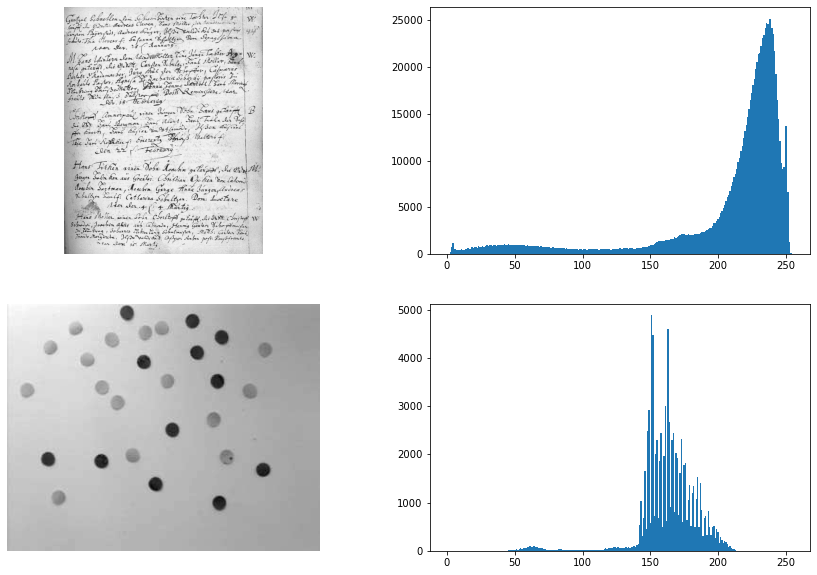

In [1]:
# Run this cell to get an impression of how the histograms look

%matplotlib inline
import matplotlib.pyplot as plt
from imageio import imread

img1 = imread('images/schrift.png')
img2 = imread('images/pebbles.jpg') 

plt.figure(figsize=(15, 10)) 
plt.gray()
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(img1)
plt.subplot(2,2,2)
plt.hist(img1.flatten(), 256, (0, 255))
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(img2)
plt.subplot(2,2,4)
plt.hist(img2.flatten(), 256, (0, 255))
plt.show()

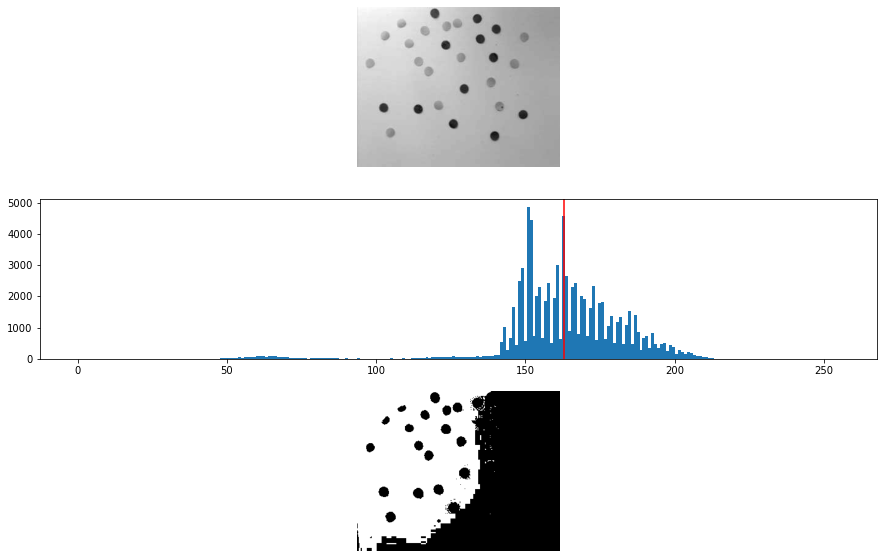

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from imageio import imread
import skimage as ski

img = imread('images/pebbles.jpg') # 'pebbles.jpg' or 'schrift.png'

thresh = ski.filters.threshold_mean(img)

segments = img > thresh

plt.figure(figsize=(15, 10))
plt.gray()
plt.subplot(3,1,1); plt.axis('off'); plt.imshow(img)
plt.subplot(3,1,2); plt.hist(img.flatten(), 256, (0,255))
plt.axvline(thresh, color='r')
plt.subplot(3,1,3); plt.axis('off'); plt.imshow(segments)
plt.show()

### c) Shading

Shading may cause a problem to histogram based segmentation. In the lecture (CV-07 slide 13), it was proposed to compute a shading image to deal with that problem. Apply this approach to the images `schrift.png` and `pebbles.jpg`. You may use filter functions from scikit-image for this exercise.

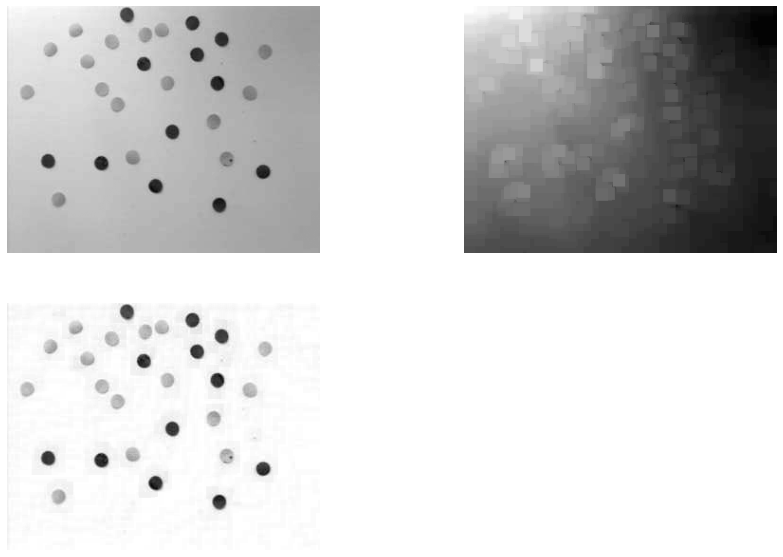

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from skimage import filters

#img = imread('images/schrift.png').astype(float)/255
img = imread('images/pebbles.jpg').astype(float)/255

shading_img = filters.rank.maximum(img, np.ones((13,13)))
shading_func = 1/shading_img

corrected_img = (img * shading_func) * (255/img.max())


plt.figure(figsize=(15, 10))
plt.gray()
plt.subplot(2,2,1); plt.axis('off'); plt.imshow(img)
plt.subplot(2,2,2); plt.axis('off'); plt.imshow(shading_img)
plt.subplot(2,2,3); plt.axis('off'); plt.imshow(corrected_img)

## Assignment 2: Pyramid representation [5 Points]

**a)** What is the *Gaussian pyramid*? How does the **reduce** operation work? Explain in your own words what low pass filtering is and why it should be used when building the pyramid? Implement the **reduce** operation and generate a figure similar to the one on (CV-07 slide 32).

The Gaussian pyramid can be used to represent multiple scales of an image. Specifically, a certain amount of pixels of an image of order i is replaced by a smaller amount of pixels in the image of order i+1. A Gaussian filter is used as kernel to compute the new pixels. Thereby, the overall amount of pixels is reduced with each layer/order. This can help extracting segments not only on one but on many different scales. 

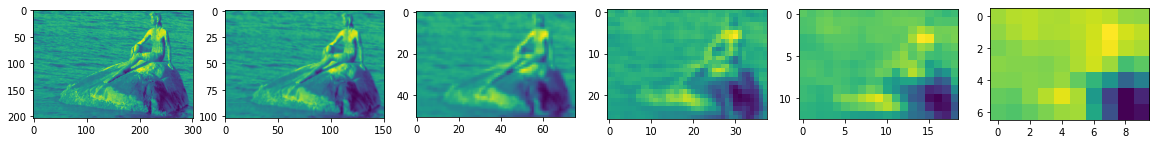

In [2]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from imageio import imread
from scipy.special import binom

img = imread('images/mermaid.png')

def reduce_op(img, kernel, stepsize=2, pad_type='reflect'):
    assert kernel.shape[0] % 2 and kernel.shape[1] % 2, 'kernel shape has to be odd!'
    img = np.pad(img, (kernel.shape, kernel.shape), pad_type)
    reduced_img = []
    for y in range(kernel.shape[0],img.shape[0]-kernel.shape[0],stepsize):
        reduced_row = []
        for x in range(kernel.shape[1],img.shape[1]-kernel.shape[1],stepsize):
            cutout = img[y-kernel.shape[0]//2:y+kernel.shape[0]//2+1, x-kernel.shape[1]//2:x+kernel.shape[1]//2+1]
            weighted_cutout = np.sum(cutout * kernel)
            reduced_row.append(weighted_cutout)
        reduced_img.append(np.array(reduced_row))
    return np.array(reduced_img)
            
def gaussian_kernel(m):
    # create gaussian kernel of size (2m+1)x(2m+1)
    binom1d = np.array([[binom(2*m, k) for k in range(2*m+1)]])
    return binom1d.T @ binom1d

kernel = gaussian_kernel(2)/np.sum(gaussian_kernel(2))
reduce_steps = 6
fig, axs = plt.subplots(1, reduce_steps)
fig.set_size_inches(20, 6)
for i in range(reduce_steps):
    img = reduce_op(img,kernel)
    axs[i].imshow(img)
plt.show()

**b)** What is the **expand** operation? Why can the **reduce** operation not be inverted? Implement the **expand** operation and generate an image similar to the one on (CV-07 slide 34).

The expand operation can help to reproduce order i from order i+1. It does so by interpolating from the pixels of the image in order i+1. The resulting image is not as sharp as the original image was before the reduce operation since this operation is not invertable. It cannot reproduce the exact information by using Gaussian, binomial or any other filtering method since these are just attempts to model the original information. It is (almost) impossible to return to the same original by interpolating from a smaller number of pixels of a higher order.

In [ ]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from imageio import imread
from scipy.special import binom

img = imread('images/mermaid.png')

def expand_op(img, kernel):
    expanded_img = np.zeros((img.shape[0]*(kernel.shape[0]//2+1) + kernel.shape[0],
                             img.shape[1]*(kernel.shape[1]//2+1) + kernel.shape[1]))
    for y,x in np.ndindex(img.shape):
        m_kernel = kernel * img[y, x]
        #print(m_kernel.astype(int))#, expanded_img[y*2:y*2+kernel.shape[0], x*2:x*2+kernel.shape[1]])
        #print((y*(kernel.shape[0]//2+1),y*(kernel.shape[0]//2+1) + kernel.shape[0]),
        #      (x*(kernel.shape[1]//2+1),x*(kernel.shape[1]//2+1) + kernel.shape[1]), expanded_img.shape)
        expanded_img[y*(kernel.shape[0]//2+1):y*(kernel.shape[0]//2+1) + kernel.shape[0],
                     x*(kernel.shape[1]//2+1):x*(kernel.shape[1]//2+1) + kernel.shape[1]] += m_kernel
    return expanded_img

def gaussian_kernel(m):
    # create gaussian kernel of size (2m+1)x(2m+1)
    binom1d = np.array([[binom(2*m, k) for k in range(2*m+1)]])
    return binom1d.T @ binom1d

kernel = gaussian_kernel(1)/np.sum(gaussian_kernel(1))

steps = 2
fig, axs = plt.subplots(1, steps+1)
fig.set_size_inches(20, 6)

for i in range(4):
    img = reduce_op(img,kernel)

axs[0].imshow(img)  

for _ in range(steps):
    print(_)
    #pyramid_image = np.zeros((img.shape[0] + (2 ** steps), img.shape[1] + (2 ** steps)))
    img = expand_op(img, kernel)
    axs[_+1].imshow(img)
plt.show()

## Assignment 3: Texture Segmentation [5 Points]

**a)** What is texture? Try to define it in your own words. Can there be a standard definition? What problems do you expect for texture based segmentation? 

Texture is a property that is shared by the same surface/surfaces. Property in this regard could mean that the surface/surfaces has/have the same or an almost similar structure, or have common absorption/reflection characteristics. In an image, texture may in rare cases differ from pixel to pixel but, usually, it spreads over a certain area or region and includes many neighbouring pixels. It is difficult to find a standard definition since the scale at which to define it may vary from very small (grass, sand, forest grounds) to very large (ocean, sky, etc.). An issue for segmentation could be that the very same texture is easy to extract in one image, but difficult to extract in another (for example, if the angle of the photograph on an object or the light source changes). For computer vision, it can be hard to differentiate between patterns as in an image they can all look very similar or share similar properties and there exist a lot of textures.

**b)** What is a co-occurence matrix? How can it be used to characterize texture?

The co-occurence matrix is a two-dimensional histogram and checks for periodicity in neighbouring pixels of a window using simple statistics. The two-dimensional window can be put anywhere in an image. For each grey value pair in the window, the co-occurence matrix calculates the probability of them sharing the same pixel values at a given offset. In the lecture, the offset is a specified distance and an angle (in our case the angle to the x-axis). The values are normalised over the squared number of pairs in the window to get the probabilities. In order to compute the co-occurence matrix, one needs to iterate over each grey value and check for the probability of each value, given the distance and angle of the pixels of the input window.


**c)** Implement a function to compute the co-occurence matrix of an image (patch). Apply it and compare your results to (CV-07 slide 54).

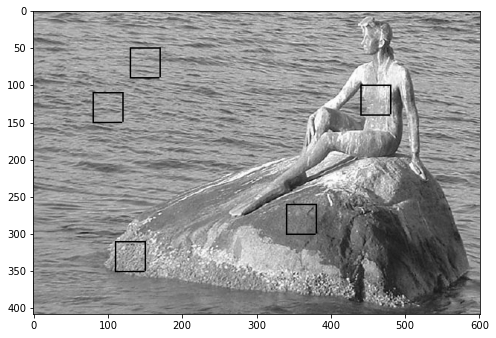

KeyboardInterrupt: 

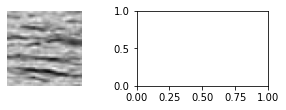

In [3]:
%matplotlib inline
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import imageio 

img = imageio.imread('images/mermaid.png')#, mode='L')

def get_patch(img, x, y, size=40):
    """
    Extract a rectangular patch from an image and mark it in the original image.
    
    Args:
        img (nndarray): Input image.
        x (uint): X-coordinate.
        y (uint): Y-coordinate.
        size (uint): Size of the patch.
        
    Returns:
        result: The extracted patch.
    """
    result = img[x:x+size,y:y+size].copy()
    img[x:x+size, [y,y+1,y+size,y+size+1]] = 0
    img[[x,x+1,x+size,x+size+1], y:y+size] = 0
    return result

patches = []
patches.append(get_patch(img, 50,130))
patches.append(get_patch(img, 110,80))
patches.append(get_patch(img, 260,340))
patches.append(get_patch(img, 310,110))
patches.append(get_patch(img, 100,440))


def cooccurrence(img, dx=1, dy=1):
    """
    Compute a co-occurence matrix for the given image.
    
    Args:
        img          the grayscale image (uint8)
        dx,dy        the offset between the two reference points

    Returns:
        matrix       the co-occurence matrix
    """
    
    matrix = np.empty((256, 256))
    
    delta = lambda x: int(x == 0)
    angle = 0
    dist = np.array([np.cos(angle),np.sin(angle)])
    
    for g1,g2 in np.ndindex(matrix.shape):
        s = 0
        for py,px in np.ndindex(img.shape):
            pd = np.floor(np.array([py,px]) + dist).astype(int)
            if np.all(pd < 40):
                s += delta(img[py,px] - g1) * delta(img[pd[1],pd[0]] - g2)
        
        prob = (1/(img.shape[0]**2)) * s
        matrix[g1,g2] = prob

    return matrix


plt.figure(figsize=(8, 8))
plt.gray()
plt.imshow(img)
plt.show()


plt.figure(figsize=(8, 8))
i = 0
for p in patches:
    plt.subplot(len(patches),3,i+1); plt.axis('off'); plt.imshow(p)
    # For visualization one may apply some extra me, e.g., logarithmization or binarization
    plt.subplot(len(patches),3,i+2); plt.imshow(np.log(1 + cooccurrence(p, 0, 1)), interpolation='none')
    plt.subplot(len(patches),3,i+3); plt.imshow(cooccurrence(p,1,0)>0, interpolation='none')
    i += 3
plt.show()

## Assignment 4: Region merging [5 Points]

Implement the *region merging* algorithm (CV-07 slide 39) and apply it to the image `segments.png` (or some part of it). Use a simple *homogeneity condition*, e.g. that the maximal difference between gray values in a segment is not larger than a given threshold.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import imageio
import warnings
warnings.filterwarnings('ignore')

img = imageio.imread('./images/segments.png', pilmode='L')
# Choosing a large image region lengthens computation time
img = img[64:128,64:128]

def check_homogeneity(regionA, regionB):
    #print(regionA, regionB)
    return 1 - abs(sum(regionA)/len(regionA) - sum(regionB)/len(regionB))/255 

threshold = 0.90


labels = np.random.permutation(img.size).reshape(img.shape)

while True:
    max_homogeneity, region_labelA, region_labelB = 0, '', ''
    # horizontal
    for y,x in np.argwhere(labels[:,:-1]!=labels[:,1:]):
        regionA = img[labels==labels[y,x]]
        regionB = img[labels==labels[y,x+1]]
        homogeneity = check_homogeneity(regionA, regionB)
        if homogeneity > max_homogeneity:
            max_homogeneity = homogeneity
            region_labelA = labels[y, x]
            region_labelB = labels[y, x+1]
    # vertical
    for y,x in np.argwhere(labels[:-1]!=labels[1:]):
        regionA = img[labels==labels[y,x]]
        regionB = img[labels==labels[y+1,x]]
        homogeneity = check_homogeneity(regionA, regionB)
        if homogeneity > max_homogeneity:
            max_homogeneity = homogeneity
            region_labelA = labels[y, x]
            region_labelB = labels[y+1, x]
    if max_homogeneity > threshold:
        labels[labels==region_labelA] = region_labelB
    else:
        break

plt.figure(figsize=(12, 12))
plt.gray()
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(labels, cmap='prism')
plt.show()

warnings.filterwarnings('ignore')

## Bonus: Painting with a webcam using color detection [0 points]


### Testing your webcam: Images
From now on we will try to make the exercises a bit more interactive and use live feed from your webcam. Unfortunately, using the webcam may not always work out of box (depending on your hardware/os configuration). So first make sure that you can grab an image from the webcam.

1. Use the `imageio` library as presented in the tutorial sessions. You will probably need to install `ffmpeg` packages as shown in the tutorial code.
1. Use the `cv2` library (opencv will use `gstreamer`). You will probably need to install then `opencv` package.

Hint: Sometimes it helps to restart the kernel.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set this flag to either use "imageio" or "cv2"
use_imageio = True
if use_imageio:
    # use imageio for accessing the webcam (requires ffmpeg to be installed on your computer)
    import imageio
    try:
        reader = imageio.get_reader('<video0>')
        img = reader.get_next_data()
        ok = True
        reader.close()
    except:
        ok = False
else:
    # use opencv for accessing the webcam
    import cv2
    camera = cv2.VideoCapture(0)
    ok, img = camera.read()
    camera.release()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if ok:
    plt.imshow(img)
    plt.show()
else:
    print("Accessing your webcam failed.")

### Testing your webcam: Video
You can now test your webcam with video. You can either select the methods presented in the tutorial session, namely `imageio` and `opencv`, or use `cvloop`. We recommend using the first method.

**imageio**


To test imageio run the following code

In [ ]:
%matplotlib notebook
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import imageio

try:
    display(HTML("press <kbd>I</kbd>, <kbd>I</kbd> (Kernel Interrupt) to stop the demo!"))
    with imageio.get_reader('<video0>') as webcam:
        fig = plt.figure(figsize=(8,6))
        mpl_image = plt.imshow(webcam.get_next_data())

        while True:
            img = webcam.get_next_data()
            mpl_image.set_data(img)
            fig.canvas.draw()
except KeyboardInterrupt:
    print("Interrupted")
finally:
    webcam.close()
    plt.close(fig)
    print("Camera was closed.")

**cvloop**

Atlernatively you can use `cvloop`. To install `cvloop` first activate your cv environment and then run the follwing cell. We recommend using

In [ ]:
!pip install cvloop

Check that it works by executing the cell below:

In [ ]:
from cvloop import cvloop
cvl = cvloop(function=lambda frame: 255 - frame, side_by_side=True)

### a)
In this task we will track a small colored object (like the cap of a pen) in front of a neutral background of a different color. We will use the location of the object to paint on a virtual canvas. For that you have to implement the following tasks in the `draw_func` function:

* Convert the image `img` given to the `draw_func` into HSV color space. 
* Measure the color of your object. You may return the converted image and interactively measure the color with your mouse. Define your measured hue value in a constant
* Discard all channel except the hue channel. 
* Find the location with the most similar hue to the measured hue of your object.
* Paint a marker, for example a circle, at this position in `img_draw`.


In [ ]:
%matplotlib inline

import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.color import rgb2hsv
from skimage.draw import disk

# Adapt this hue value to the hue of your object
hue = .2

# A global canvas to draw on
canvas = np.zeros((480,640,3), np.uint8) 

# radius and color of the brush
radius = 5
color = (255,255,255)

# saturation threshold for object
thresh = .2

def draw_func(img):
    """
    Draw a circle on img_draw at the detected object location.
    
    Args:
        img          the RGB input image (uint8)

    Returns:
        img_draw     img with circle drawn at postion of object
    """
    global canvas, hue, radius, color
    
    # YOUR CODE HERE
    
    
    return canvas



# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(8, 1))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cb = mpl.colorbar.ColorbarBase(ax, cmap=mpl.cm.hsv, orientation='horizontal',
                               norm=mpl.colors.Normalize(vmin=0, vmax=1))
cb.set_ticks([hue])
cb.set_label('the hue value')
plt.show()

First test your function with single image. You may either grab an image from your webcam (as described above), or choose an arbitrary image from wherever you like

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt

draw_func(img)
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(canvas)
plt.show()

Now run your function on video with imageio or alternatively with cvloop

In [ ]:
# imageio
%matplotlib notebook
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import imageio

try:
    display(HTML("press <kbd>I</kbd>, <kbd>I</kbd> (Kernel Interrupt) to stop the demo!"))
    with imageio.get_reader('<video0>') as webcam:
        fig = plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        mpl_image1 = plt.imshow(webcam.get_next_data())
        plt.subplot(1,2,2)
        mpl_image2 = plt.imshow(webcam.get_next_data())

        while True:
            img = webcam.get_next_data()
            # mirror the image to make drawing easier
            img = img[:,::-1,:]
            img_processed = draw_func(img)
            mpl_image1.set_data(img)
            mpl_image2.set_data(img_processed)
            fig.canvas.draw()
except KeyboardInterrupt:
    print("Interrupted")
finally:
    webcam.close()
    plt.close(fig)
    print("Camera was closed.")

In [ ]:
# cvloop
%matplotlib notebook
from cvloop import cvloop

# Now use cvloop to run the algorithm live on webcam data     
cvl = cvloop(function=draw_func, side_by_side=True)